# ガウス過程回帰 Gaussian process regression

## ガウス過程 Gaussian process

$t  = y + ε$ としたときに  
$$
p(t|y) = N(t|y, 1/β I )
$$  
ただし$β = 1/ε^2$  
  
$$
p(y) = N(y|0, K)
$$  
予測には$p(t)$を求める  

$$
p(t) = \int p(t|y)p(y)dy = N(t|0, C) \\
C(x_n, x_m) = k(x_n, x_m) + β^{-1} δ_{m,n}
$$

In [1]:
using PyCall, PyPlot
using Distributions

### クロネッカーのデルタ Kronecker's delta
$i=j$のときだけ$\delta_{i,j}=1$、それ以外は$\delta_{i,j}=0$となる関数。  
行列の対角成分にんだけ処理をしたい場合に使う。正方行列を使っても同じことができる。

In [2]:
function kronecker(i, j)
    if i == j
        return 1
    else
        return 0
    end
end

kronecker (generic function with 1 method)

### カーネル関数 Kernel function
二つのベクトルの”近さ”をスカラで返す関数。 

下記はガウシアンカーネルを実装。RBFとも呼ばれる。カーネル関数$k()$
$$
    k(x_1, x_2) = a^2 \exp\{-\frac{1}{2}(x_1 - x_2)\Lambda(x_1-x_2)\}  \\
    \Lambda = Diag(\sigma_0^2, \sigma_1^2, ... , \sigma_n^2)^{-1} \\
$$
  
この書き方もよく見るけど、これだと入力ベクトルの各要素ごとの分散を別々に扱えない気がする。
$$
    k(x_1, x_2) = a^2 \exp(-\frac{1}{2}\frac{||x_1 - x_2||^2}{\sigma^2} )  \\
$$

In [10]:
function kernel(x1, x2, theta)
    # 任意の字数のベクトルの写像
    # NOTE: theta= [σf, σl0, σl1,...]
    # if length(x1) != length()
    sigf = theta[1]
    sigls = theta[2:end]
    L    = inv(Diagonal(sigls))^2
    coef = ((x1 - x2)' * L * (x1 - x2))[1] # 1x1になってしまうため、要素をとりだして数値にする
    return (sigf^2) * exp(-1/2.0 * coef)
end;

### グラム行列 Gram matrix
※カーネルによっては反正定値行列ではないが。。。

In [11]:
function gram_matrix(x1, x2, theta)
    n = size(x1)[1]
    m = size(x2)[1]
    K = zeros(n, m)

    for i=1:n
        for j=1:m
            K[i, j] = kernel(x1[i], x2[j], theta) 
        end
    end
    return K
end

gram_matrix (generic function with 1 method)

## 対数尤度
$D$次元ガウス分布$N(x|\mu, \Sigma)$の対数表示は
$$
\ln{N(x|\mu, \Sigma)}=-\frac{1}{2}\{  (x-\mu)^T \Sigma^{-1} (x-\mu) + \ln{\det{\Sigma}} + D\ln{2\pi}    \}
$$

ハイパーパラメータは、$\ln{p(\boldsymbol{t} | \boldsymbol{\theta})}$を最大にするようにして決定する。
これもガウス分布なので同様に変形できる。
$$
\ln{p(\boldsymbol{t} | \boldsymbol{\theta})}=-\frac{1}{2}\{\boldsymbol{t}^T \textbf{C}_N^{-1} \boldsymbol{t} + \ln{\det{\textbf{C}_N}} + D\ln{2\pi}    \}
$$

もし$K$が半正定値行列出ない場合、$\det{K}$が負となるため対数が計算できない。

In [12]:
function log_likelihood(x, y, b, theta)
    t = y
    n = size(x)[1]
    K= gram_matrix(x, x, theta)
    C = K + eye(n)/b
    tCt = t' * inv(C) * t
    logdetC = logdet(C)  # log(det(C))
    return  -1/2.0 * tCt - 1/2.0 * logdetC - n/2.0 * log(2*pi)
end

log_likelihood (generic function with 1 method)

### 共分散行列$C_N$の偏微分
勾配法で超パラメタをきめるときの準備

In [13]:
function deriv2(x1, x2, theta)

    # パラメータaでの微分
    delta_0 = 2 * theta[1] * exp(-0.5* (norm(x1-x2) / theta[2])^2 ) 

    # パラメータbでの微分
    delta_1 = (theta[1]^2) / (theta[2]^3) *( norm(x1-x2)^2) *  exp(-0.5* (norm(x1-x2) / theta[2])^2 ) 
    
    return [delta_0, delta_1]
end;

## 実験
ガウス過程回帰の実験
- パラメータ適当
- 勾配法でパラメータ推定
- ランダムにサンプリングで推定
- MCMCで推定

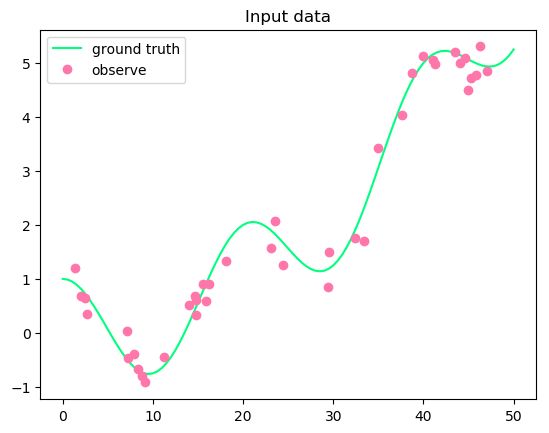

PyObject <matplotlib.legend.Legend object at 0x000000002C7E5FD0>

In [14]:
function y(x)
    return cos(pi/10*x) + x^2/400
end

n = 40
b = 20 

x_obs = rand(n)*50
sige2 = 0.25

y_obs = y.(x_obs) + rand(Normal(0, sige2), n);
x = linspace(0, 50, 101);

figure("result")
clf()
plot(x, y.(x), c="springgreen", label="ground truth")
plot(x_obs, y_obs, "o", c="#ff77aa", label="observe")
title("Input data")
legend()

### 適当なパラメータ

In [16]:
# Regression
b = 1.0/0.5 # そこそこうまくいく
th = [1.0, 7.0]　# そこそこうまくいく

b = 1.0/0.1 # うまくいかない
th = [1.0, 1.0]　# うまくいかない

# 共分散行列の計算
K = gram_matrix(x_obs, x_obs, th)
n = size(y_obs)[1]
C_N = K + eye(n)/b

# 平均値の計算
m_list = []
for j = 1:length(x)
    k = [kernel(x_obs[i, :], x[j], th) for i =1:length(y_obs)]
    m =   k' *  inv(C_N)  * y_obs
    push!(m_list, m[1])
end

# 分散の計算
Sig2_list = []
for j = 1:length(x)
    k = [kernel(x_obs[i, :], x[j], th) for i =1:length(y_obs)]
    c = kernel(x[j], x[j], th) + 1/b
    push!(Sig2_list, c - k' * inv(C_N) * k)
end

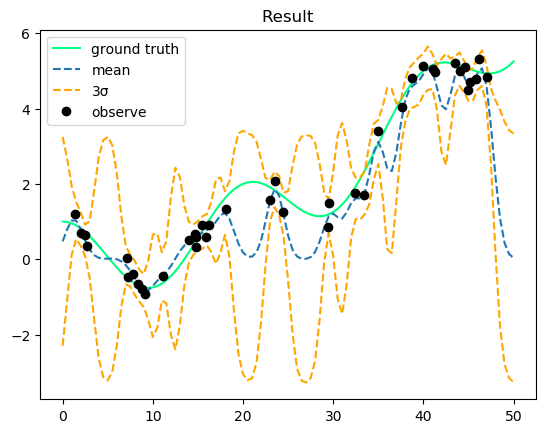

In [17]:
figure("result")
clf()
plot(x, y.(x), c="springgreen", label="ground truth")
plot(x, m_list, "--", label="mean")
plot(x, m_list - 3*Sig2_list, "--", c="orange")
plot(x, m_list + 3*Sig2_list, "--", c="orange", label="3σ")
plot(x_obs, y_obs, "o", c="k", label="observe")
title("Result")
legend();

適当に決めたパラメータではうまくいかないし、うまくいっても根拠がない。

## 勾配法
あるパラメータが選ばれた時に観測データを観測する尤度について、これを最大化するように超パラメタを決める。  
要は、最尤推定をするのに勾配法を使う。

In [66]:
# learning rate
alpha = 0.001
b = 20
max_iter = 10000
param =  [2.0, 1.0]
params = []
grads1 = []
grads2 = []
log_likelihood_hist = []

params = []
push!(params, copy(param))

eps =  0.001 # stop condition

# 更新前の値
prev_log_likelihood = log_likelihood(x_obs, y_obs, b, param)
println(prev_log_likelihood)
prev_param = copy(param)

for it =1:max_iter
    
    #  fit
    K = gram_matrix(x_obs, x_obs, param)
    n = size(y_obs)[1]
    C_N = K + eye(n)/b
    
    x1 = copy(x_obs)
    x2 = copy(x_obs)
    n = size(x1)[1]
    m = size(x2)[1]
    d1_C_N = zeros(n, m)
    d2_C_N = zeros(n, m)

    for i=1:n
        for j=1:m
            # println(deriv(x1[i], x2[j], theta)[1])
            d1_C_N[i, j] = deriv2(x1[i], x2[j], param)[1]
            d2_C_N[i, j] = deriv2(x1[i], x2[j], param)[2]
        end
    end
    
    d1_evidence = -0.5 * trace( inv(C_N) * d1_C_N ) + 0.5 * y_obs' * inv(C_N) * d1_C_N * inv(C_N) * y_obs
    d2_evidence = -0.5 * trace( inv(C_N) * d2_C_N ) + 0.5 * y_obs' * inv(C_N) * d2_C_N * inv(C_N) * y_obs
    
    # 値の更新
    param[1]  = param[1] + alpha * d1_evidence
    param[2]  = param[2] + alpha * d2_evidence
    log_likelihood_var = log_likelihood(x_obs, y_obs, b, param)
    
        
    # ログ
    push!(grads1, d1_evidence)
    push!(grads2, d2_evidence)
    push!(log_likelihood_hist, log_likelihood_var)
    push!(params, copy(param))
    
    # 前回値との比較
    diff_var = abs(log_likelihood_var - prev_log_likelihood)
    if diff_var < eps
        println("break!!")
        print(it)
        println(" iter")

        break
    end
    
    # 値を保存
    prev_param = copy(param)
    prev_log_likelihood = log_likelihood_var
    
end
best_param = copy(param)
println(best_param)

-69.60004458781302
break!!
1167 iter
[2.30047, 6.2924]


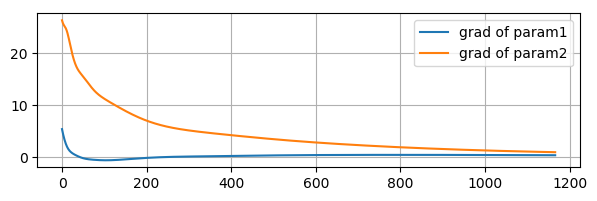

In [67]:
fig = figure(figsize=(7,2))
plot(grads1, label="grad of param1", "-")
plot(grads2, label="grad of param2", "-")
legend()
# ylim([-0.1, 0.1])
grid()

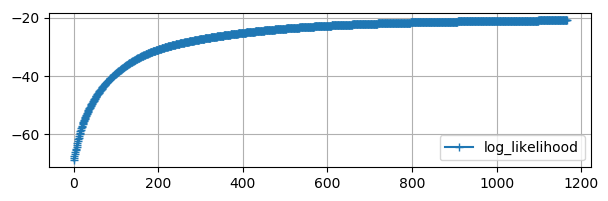

In [68]:
fig = figure(figsize=(7,2))
plot(log_likelihood_hist, label="log_likelihood", "-+")
legend()
grid()

In [69]:
# Regression
K = gram_matrix(x_obs, x_obs, best_param)
n = size(y_obs)[1]
b = 20 # bの微分を求めるのを忘れていた。。
C_N = K + eye(n)/b

m_list = []
for j = 1:length(x)
    k = [kernel(x_obs[i, :], x[j], th)[1] for i =1:length(y_obs)]
    m =   k' *  inv(C_N)  * y_obs
    push!(m_list, m[1])
end

Sig2_list = []
for j = 1:length(x)
    k = [kernel(x_obs[i, :], x[j], param)[1] for i =1:length(y_obs)]
    # push!(Sig2_list, kernel(x[j], x[j], theta) + sige2 - k' * inv(C_N) * k)
    push!(Sig2_list, kernel(x[j], x[j], param) + 1/b  - k' * inv(C_N) * k)
end

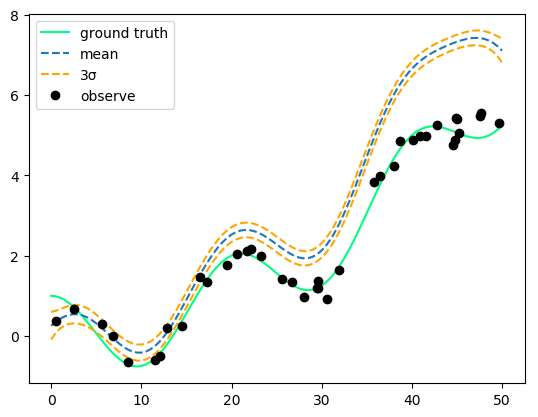

[2.30047, 6.2924]


In [70]:
figure("result")
clf()
plot(x, y.(x), c="springgreen", label="ground truth")
plot(x, m_list, "--", label="mean")
plot(x, m_list - 3*Sig2_list, "--", c="orange")
plot(x, m_list + 3*Sig2_list, "--", c="orange", label="3σ")
plot(x_obs, y_obs, "o", c="k", label="observe")
println(param)
legend();

対数尤度関数は非線形なので、容易に局所解にハマる。

## ランダムサンプリング
モンテカルロ的にパラメータを決めて見る。単純に、何も考えずにパラメータを選んで、尤度が最大になったものを選ぶ方法。

In [23]:
num_random_param = 5000
random_params = rand(num_random_param,3)*10;

In [24]:
# learning rate
best_likelihood = -1000
best_param = [0, 0, 0]
for i = 1:num_random_param
    param = random_params[i, :]
    log_likelihood_var = log_likelihood(x_obs, y_obs, param[1], param[2:end])
    
    if log_likelihood_var > best_likelihood
        best_likelihood = copy(log_likelihood_var)
        best_param = copy(param)
    end
end
println("Best parameters:")
println(best_param)

Best parameters:
[9.71533, 3.196, 8.75031]


In [50]:
# Regression
b = best_param[1]
param = best_param[2:end]
x = linspace(0, 50, 101)

K = gram_matrix(x_obs, x_obs, param)
n = size(y_obs)[1]
C_N = K + eye(n)/b

m_list = []
for j = 1:length(x)
    k = [kernel(x_obs[i, :], x[j], param)[1] for i =1:length(y_obs)]
    m =   k' *  inv(C_N)  * y_obs
    push!(m_list, m[1])
end

Sig2_list = []
for j = 1:length(x)
    k = [kernel(x_obs[i, :], x[j], param)[1] for i =1:length(y_obs)]
    # push!(Sig2_list, kernel(x[j], x[j], theta) + sige2 - k' * inv(C_N) * k)
    push!(Sig2_list, kernel(x[j], x[j], param) + 1/b  - k' * inv(C_N) * k)
end

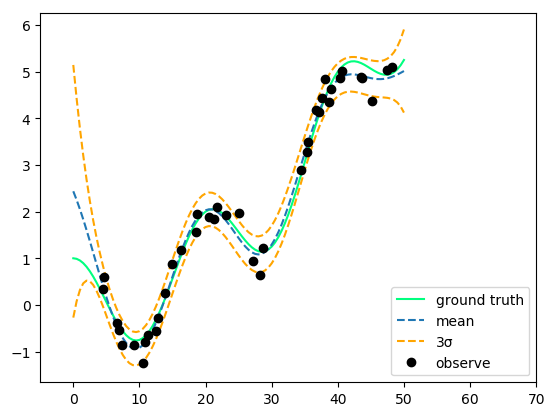

[3.196, 8.75031]


In [51]:
figure("result")
clf()
plot(x, y.(x), c="springgreen", label="ground truth")
plot(x, m_list, "--", label="mean")
plot(x, m_list - 3*Sig2_list, "--", c="orange")
plot(x, m_list + 3*Sig2_list, "--", c="orange", label="3σ")
plot(x_obs, y_obs, "o", c="k", label="observe")
xlim([-5, 70])
println(param)
legend();

たまにまぐれでいいやつがえらばれることもある。

### MCMCによるパラメータ推定
尤度関数をMCMCで推定する。
meshgridを使いたいのでPyCallを使う。

その前にまずMCMCで関数の最大値を求める練習をする。

In [52]:
using PyCall
println(PyCall.pyversion)      # python のバージョンを表示
println(PyCall.pyprogramname)  # python の絶対パス
println(PyCall.libpython)      # python lib のパス
println(PyCall.conda)          # Conda Python をつかっているか true, false
@pyimport numpy

3.6.5
c:\ProgramData\Anaconda3\python.exe
c:\ProgramData\Anaconda3\python36
false


### ガウス過程の超パラメタをMCMCで推定

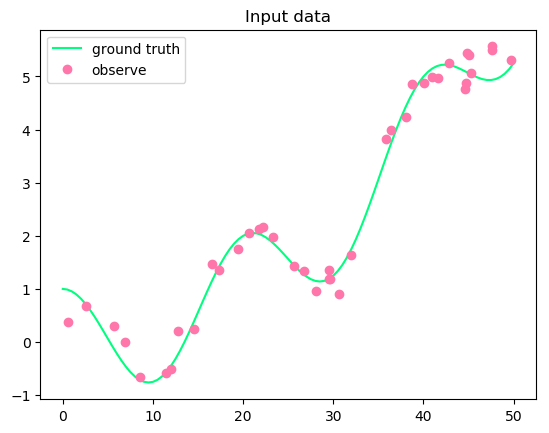

PyObject <matplotlib.legend.Legend object at 0x0000000036B1BDD8>

In [58]:
function y(x)
    return cos(pi/10*x) + x^2/400
end

n = 40
b = 20 

x_obs = rand(n)*50
sige2 = 0.25

y_obs = y.(x_obs) + rand(Normal(0, sige2), n);
x = linspace(0, 50, 101);

figure("result")
clf()
plot(x, y.(x), c="springgreen", label="ground truth")
plot(x_obs, y_obs, "o", c="#ff77aa", label="observe")
title("Input data")
legend()

In [59]:
param0 = [3.0, 0.6, 0.5] # パラメータの初期値 [b, theta1, theta2]
bound = [1e-2 1e2  # b
         1e-2 1e2  # theta1
         1e-2 1e2] # theta2 下限上限
logbound = log.(bound)
s = (logbound[:,2] - logbound[:,1])/10.0
n_param = length(param0)
logparam0 = log.(param0)

p0 = log_likelihood(x_obs, y_obs, param0[1], param0[2:end])
lis_logparam = []
lis_p = []
n = 5000

for i = 1:n
    idou = rand(Normal(0,s[1]),n_param) # 移動する距離
    is_logparam_small = (logparam0 + idou) .< logbound[:, 1]
    is_logparam_big = (logparam0 + idou) .> logbound[:, 2]
    is_logparam_outside = (is_logparam_small .& is_logparam_big) 
    # 枠外になるまでサンプリングを繰り返す
    while(numpy.any(is_logparam_outside))
        println("samping again")
        idou = rand(Normal(0,s[1]),n_param)[is_logparam_outside] # 移動する距離
        is_logparam_small = (logparam0 + idou) .< logbound[:, 1]
        is_logparam_big = (logparam0 + idou) .> logbound[:, 2]
        is_logparam_outside = (is_logparam_small .& is_logparam_big) 
    end
    
    logparam1 = logparam0 + idou
    param1 = exp.(logparam1)
    p1 = log_likelihood(x_obs, y_obs, param1[1], param1[2:end])
    r = exp(p1-p0)
    # println(r)
    
    # 比率は1より高い場合は常に移動するが、低い場合は確率で移動する
    if (r > 1.0) | (r > rand())
        logparam0 = logparam1 # 現在の位置を新しい位置に移動する
        p0 = p1
        push!(lis_logparam, logparam0) # 新しい位置を格納
        push!(lis_p,  p0) # 新しい確率を格納
        # println("push!")
    end
end

# 最大の場所
if (length(lis_p) == 0)
    println("err! no elements!")
else
    # println(lis_p)
    maxvar, ind =findmax(lis_p)

    lp1 = [e[1] for e in lis_logparam]
    lp2 = [e[2] for e in lis_logparam]
    lp3 = [e[3] for e in lis_logparam]
    lp1[ind]
    p1max = exp(lp1[ind])
    p2max = exp(lp2[ind])
    p3max = exp(lp3[ind])
    # println(p1max, ", ", p2max, ", ", p3max)
end

# self.kernel.param = np.exp(lis_theta[np.argmax(lis_p)])
# self.k00 = self.kernel(*np.meshgrid(x0,x0))
# self.k00_1 = np.linalg.inv(self.k00)

6.782152320150102

In [60]:
# Regression

b = p1max
th = [p2max, p3max]
x = linspace(0, 50, 101)

K = gram_matrix(x_obs, x_obs, th)
n = size(y_obs)[1]
C_N = K + eye(n)/b

m_list = []
for j = 1:length(x)
    k = [kernel(x_obs[i, :], x[j], th) for i =1:length(y_obs)]
    m =   k' *  inv(C_N)  * y_obs
    push!(m_list, m[1])
end

Sig2_list = []
for j = 1:length(x)
    k = [kernel(x_obs[i, :], x[j], th) for i =1:length(y_obs)]
    c = kernel(x[j], x[j], th) + 1/b
    push!(Sig2_list, c - k' * inv(C_N) * k)
end

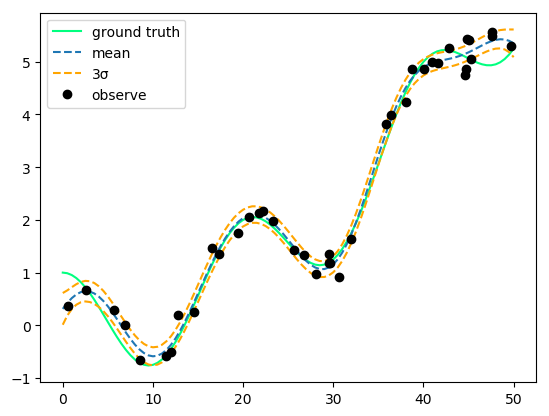

[3.196, 8.75031]


In [61]:
figure("result")
clf()
plot(x, y.(x), c="springgreen", label="ground truth")
plot(x, m_list, "--", label="mean")
plot(x, m_list - 3*Sig2_list, "--", c="orange")
plot(x, m_list + 3*Sig2_list, "--", c="orange", label="3σ")
plot(x_obs, y_obs, "o", c="k", label="observe")
println(param)
legend();

MCMCで求めた超パラメータを使った。うまくいっているように見える。